In [1]:
import os
import gc
import glob
import random
import sys
# sys.path.append('../input/iterativestratification')
import pickle
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from datetime import date, datetime

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import KFold , StratifiedKFold, GroupKFold
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import RobustScaler, MinMaxScaler, MultiLabelBinarizer

from imblearn.under_sampling import RandomUnderSampler

# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from catboost import Pool
from gensim.models import word2vec
# from tabpfn import TabPFNClassifier
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:100]

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x="feature_importance", 
                  y="column", 
                  order=order, 
                  ax=ax, 
                  palette="viridis", 
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax

In [3]:
def create_kfold_seen(df):
    sgk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    df["kfold"] = -1
    for i, (tr_id, va_id) in enumerate(sgk.split(df, df["score"].values)):
        df.loc[va_id, "kfold"] = int(i)
    return df

def create_kfold_unseen(df):
    sgk = GroupKFold(n_splits=5)
    df["kfold"] = -1
    for i, (tr_id, va_id) in enumerate(sgk.split(df, df["user_id"], df["user_id"])):
        df.loc[va_id, "kfold"] = int(i)   
    return df

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(0)

In [5]:
train_df = pd.read_csv("/kaggle/input/atmacup-15-preprocess/train_df.csv")
test_df = pd.read_csv("/kaggle/input/atmacup-15-preprocess/test_df.csv")
test_seen_df = test_df[test_df["user_id"].isin(train_df["user_id"].unique())].reset_index(drop=True)
test_unseen_df = test_df[~test_df["user_id"].isin(train_df["user_id"].unique())].reset_index(drop=True)

In [6]:
cat_params = {
    "eval_metric" : 'RMSE',
    "iterations": 10000,
    "random_seed": 42
}

# Seen_Cat

In [7]:
train_seen_df = train_df.copy()
train_seen_df = create_kfold_seen(train_seen_df)
print(len(train_seen_df))
train_seen_df = train_seen_df[train_seen_df["user_id"].isin(test_seen_df["user_id"].unique())]
print(len(train_seen_df))
drop_col = ["user_id", "anime_id", "japanese_name", "genres", "producers", 
            "licensors", "studios", "aired", "score", "kfold"]

136401
136345


In [8]:
oof_df = pd.DataFrame()
models = []
cat_test_preds = []
scores = []
for fold in range(5):
    print(f"*****fold:{fold}******")
    train_data = train_seen_df[train_seen_df["kfold"]!=fold].reset_index(drop=True)
    valid_data = train_seen_df[train_seen_df["kfold"]==fold].reset_index(drop=True)
    
    feature_cols = [col for col in train_data.columns if col not in drop_col]
    tr_fold = Pool(train_data[feature_cols], train_data["score"])
    va_fold = Pool(valid_data[feature_cols], valid_data["score"])
    
    model = CatBoostRegressor(**cat_params)
    model.fit(
        tr_fold,
        eval_set=va_fold,
        verbose=200,
        use_best_model=True,
        early_stopping_rounds=50,
    )

    models.append(model)
    file = f'cat_seen_model_{fold}.pkl'
    pickle.dump(model, open(file, 'wb'))
    
    y_pred = model.predict(valid_data[feature_cols])    
    score = np.sqrt(mean_squared_error(valid_data["score"].values, y_pred))
    print(f"*****valid_score:{score}******")
    valid_data["cat_pred"] = y_pred
    oof_df = pd.concat([oof_df, valid_data])
    cat_test_preds.append(model.predict(test_seen_df[feature_cols]))

*****fold:0******
Learning rate set to 0.026111
0:	learn: 1.5572581	test: 1.5571444	best: 1.5571444 (0)	total: 491ms	remaining: 1h 21m 49s
200:	learn: 1.3112429	test: 1.3154565	best: 1.3154565 (200)	total: 1m 11s	remaining: 58m 22s
400:	learn: 1.2483177	test: 1.2585346	best: 1.2585346 (400)	total: 2m 18s	remaining: 55m 16s
600:	learn: 1.2092669	test: 1.2258091	best: 1.2258091 (600)	total: 3m 22s	remaining: 52m 50s
800:	learn: 1.1824749	test: 1.2056516	best: 1.2056516 (800)	total: 4m 28s	remaining: 51m 23s
1000:	learn: 1.1622221	test: 1.1922258	best: 1.1922258 (1000)	total: 5m 34s	remaining: 50m 6s
1200:	learn: 1.1453907	test: 1.1828038	best: 1.1828038 (1200)	total: 6m 39s	remaining: 48m 50s
1400:	learn: 1.1310794	test: 1.1756580	best: 1.1756580 (1400)	total: 7m 43s	remaining: 47m 27s
1600:	learn: 1.1181020	test: 1.1695425	best: 1.1695425 (1600)	total: 8m 48s	remaining: 46m 9s
1800:	learn: 1.1064137	test: 1.1649561	best: 1.1649561 (1800)	total: 9m 50s	remaining: 44m 49s
2000:	learn: 1.0

In [9]:
seen_score = np.sqrt(mean_squared_error(oof_df["score"].values, oof_df["cat_pred"].values))
print(seen_score)
oof_df[["user_id", "anime_id", "score", "cat_pred"]].to_csv("cat_seen_oof_df.csv", index=False)

1.1150184745416982


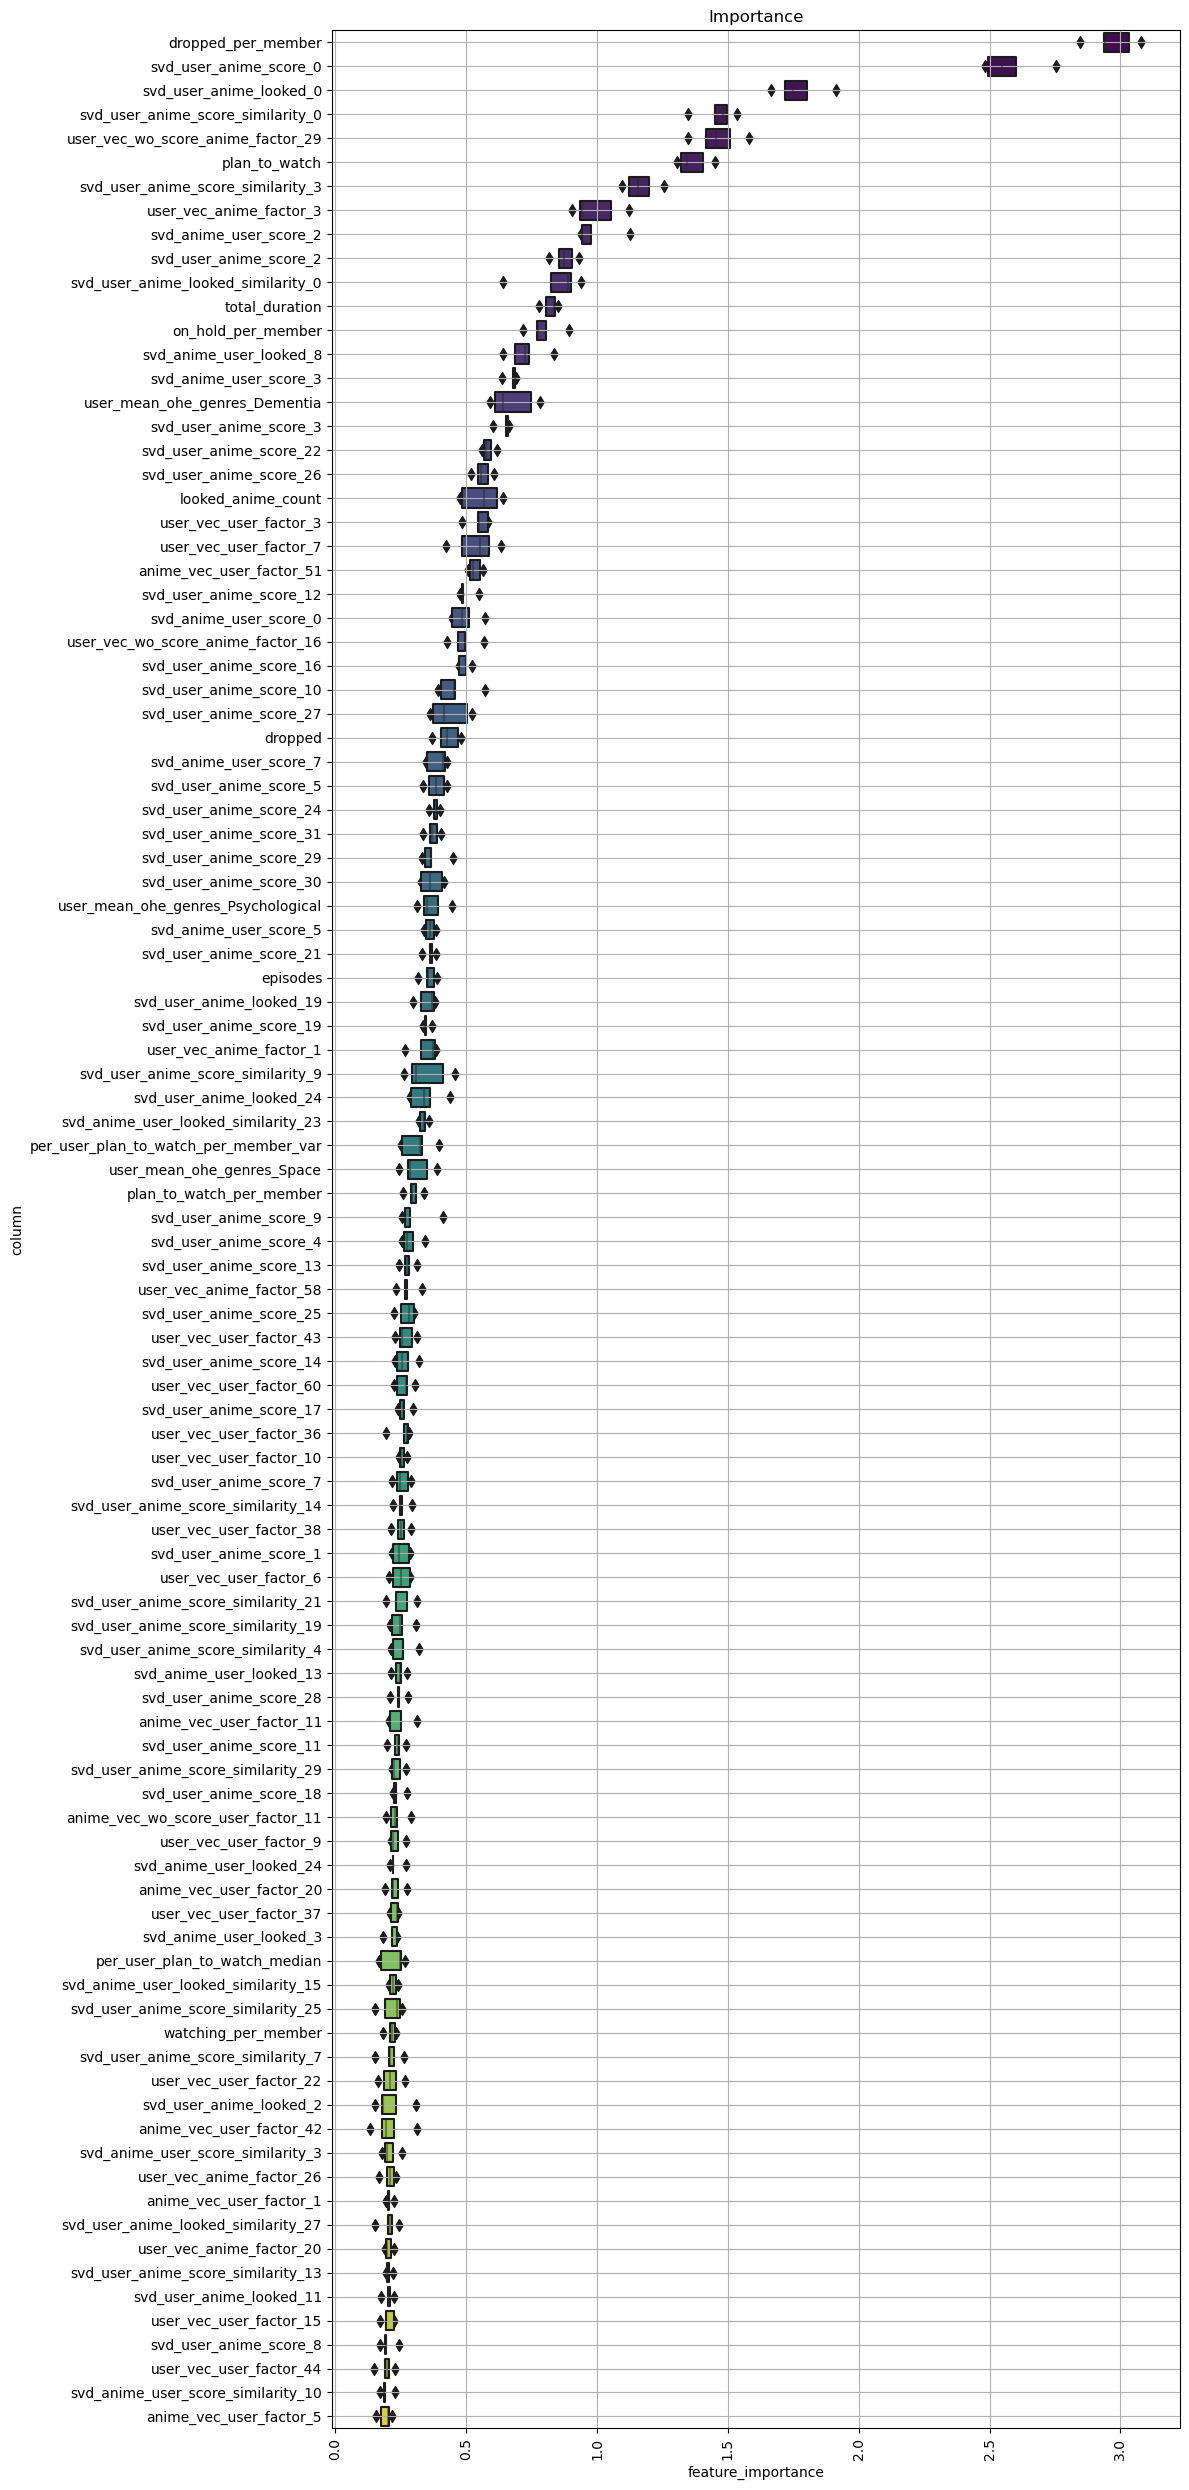

In [10]:
fig, ax = visualize_importance(models, train_data[feature_cols])

# UnSeen_Cat

In [11]:
train_unseen_df = train_df.copy()
train_unseen_df = create_kfold_unseen(train_unseen_df)

In [12]:
null_col = test_unseen_df.isnull().sum()[test_unseen_df.isnull().sum()>len(test_unseen_df)/10].index.tolist()

drop_col = ["user_id", "anime_id", "japanese_name", "genres", "producers", 
            "licensors", "studios", "aired", "score", "kfold", "user_score_var", "user_score_median", "user_score_mean"]

drop_col = drop_col + null_col

In [13]:
oof_df2 = pd.DataFrame()
models = []
cat_test_preds2 = []
scores = []
for fold in range(5):
    print(f"*****fold:{fold}******")
    train_data = train_unseen_df[train_unseen_df["kfold"]!=fold].reset_index(drop=True)
    valid_data = train_unseen_df[train_unseen_df["kfold"]==fold].reset_index(drop=True)
    
    feature_cols = [col for col in train_data.columns if col not in drop_col]
    tr_fold = Pool(train_data[feature_cols], train_data["score"])
    va_fold = Pool(valid_data[feature_cols], valid_data["score"])
    
    model = CatBoostRegressor(**cat_params)
    model.fit(
        tr_fold,
        eval_set=va_fold,
        verbose=200,
        early_stopping_rounds=50,
    )

    models.append(model)
    file = f'cat_unseen_model_{fold}.pkl'
    pickle.dump(model, open(file, 'wb'))
    
    y_pred = model.predict(valid_data[feature_cols])    
    score = np.sqrt(mean_squared_error(valid_data["score"].values, y_pred))
    print(f"*****valid_score:{score}******")
    valid_data["cat_pred"] = y_pred
    oof_df2 = pd.concat([oof_df2, valid_data])
    cat_test_preds2.append(model.predict(test_unseen_df[feature_cols]))

*****fold:0******
Learning rate set to 0.026112
0:	learn: 1.5653493	test: 1.5263563	best: 1.5263563 (0)	total: 465ms	remaining: 1h 17m 27s
200:	learn: 1.3278567	test: 1.3799802	best: 1.3797278 (198)	total: 52.6s	remaining: 42m 45s
400:	learn: 1.2614469	test: 1.3687336	best: 1.3687241 (398)	total: 1m 41s	remaining: 40m 40s
600:	learn: 1.2198702	test: 1.3628895	best: 1.3628895 (600)	total: 2m 29s	remaining: 39m
800:	learn: 1.1923675	test: 1.3585451	best: 1.3585298 (799)	total: 3m 16s	remaining: 37m 38s
1000:	learn: 1.1725565	test: 1.3544411	best: 1.3544411 (1000)	total: 4m 2s	remaining: 36m 21s
1200:	learn: 1.1560296	test: 1.3527589	best: 1.3527229 (1194)	total: 4m 49s	remaining: 35m 24s
1400:	learn: 1.1417206	test: 1.3512668	best: 1.3511370 (1377)	total: 5m 36s	remaining: 34m 24s
1600:	learn: 1.1289041	test: 1.3500655	best: 1.3500589 (1598)	total: 6m 24s	remaining: 33m 37s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.349397329
bestIteration = 1691

Shrink model to

In [14]:
unseen_score = np.sqrt(mean_squared_error(oof_df2["score"].values, oof_df2["cat_pred"].values))
print(seen_score, unseen_score)
all_score = np.sqrt(0.77*seen_score**2 + 0.23*unseen_score**2)
print(f"########{all_score}#######")

oof_df2[["user_id", "anime_id", "score", "cat_pred"]].to_csv("cat_unseen_oof_df.csv", index=False)

1.1150184745416982 1.387355757600281
########1.1832196974662343#######


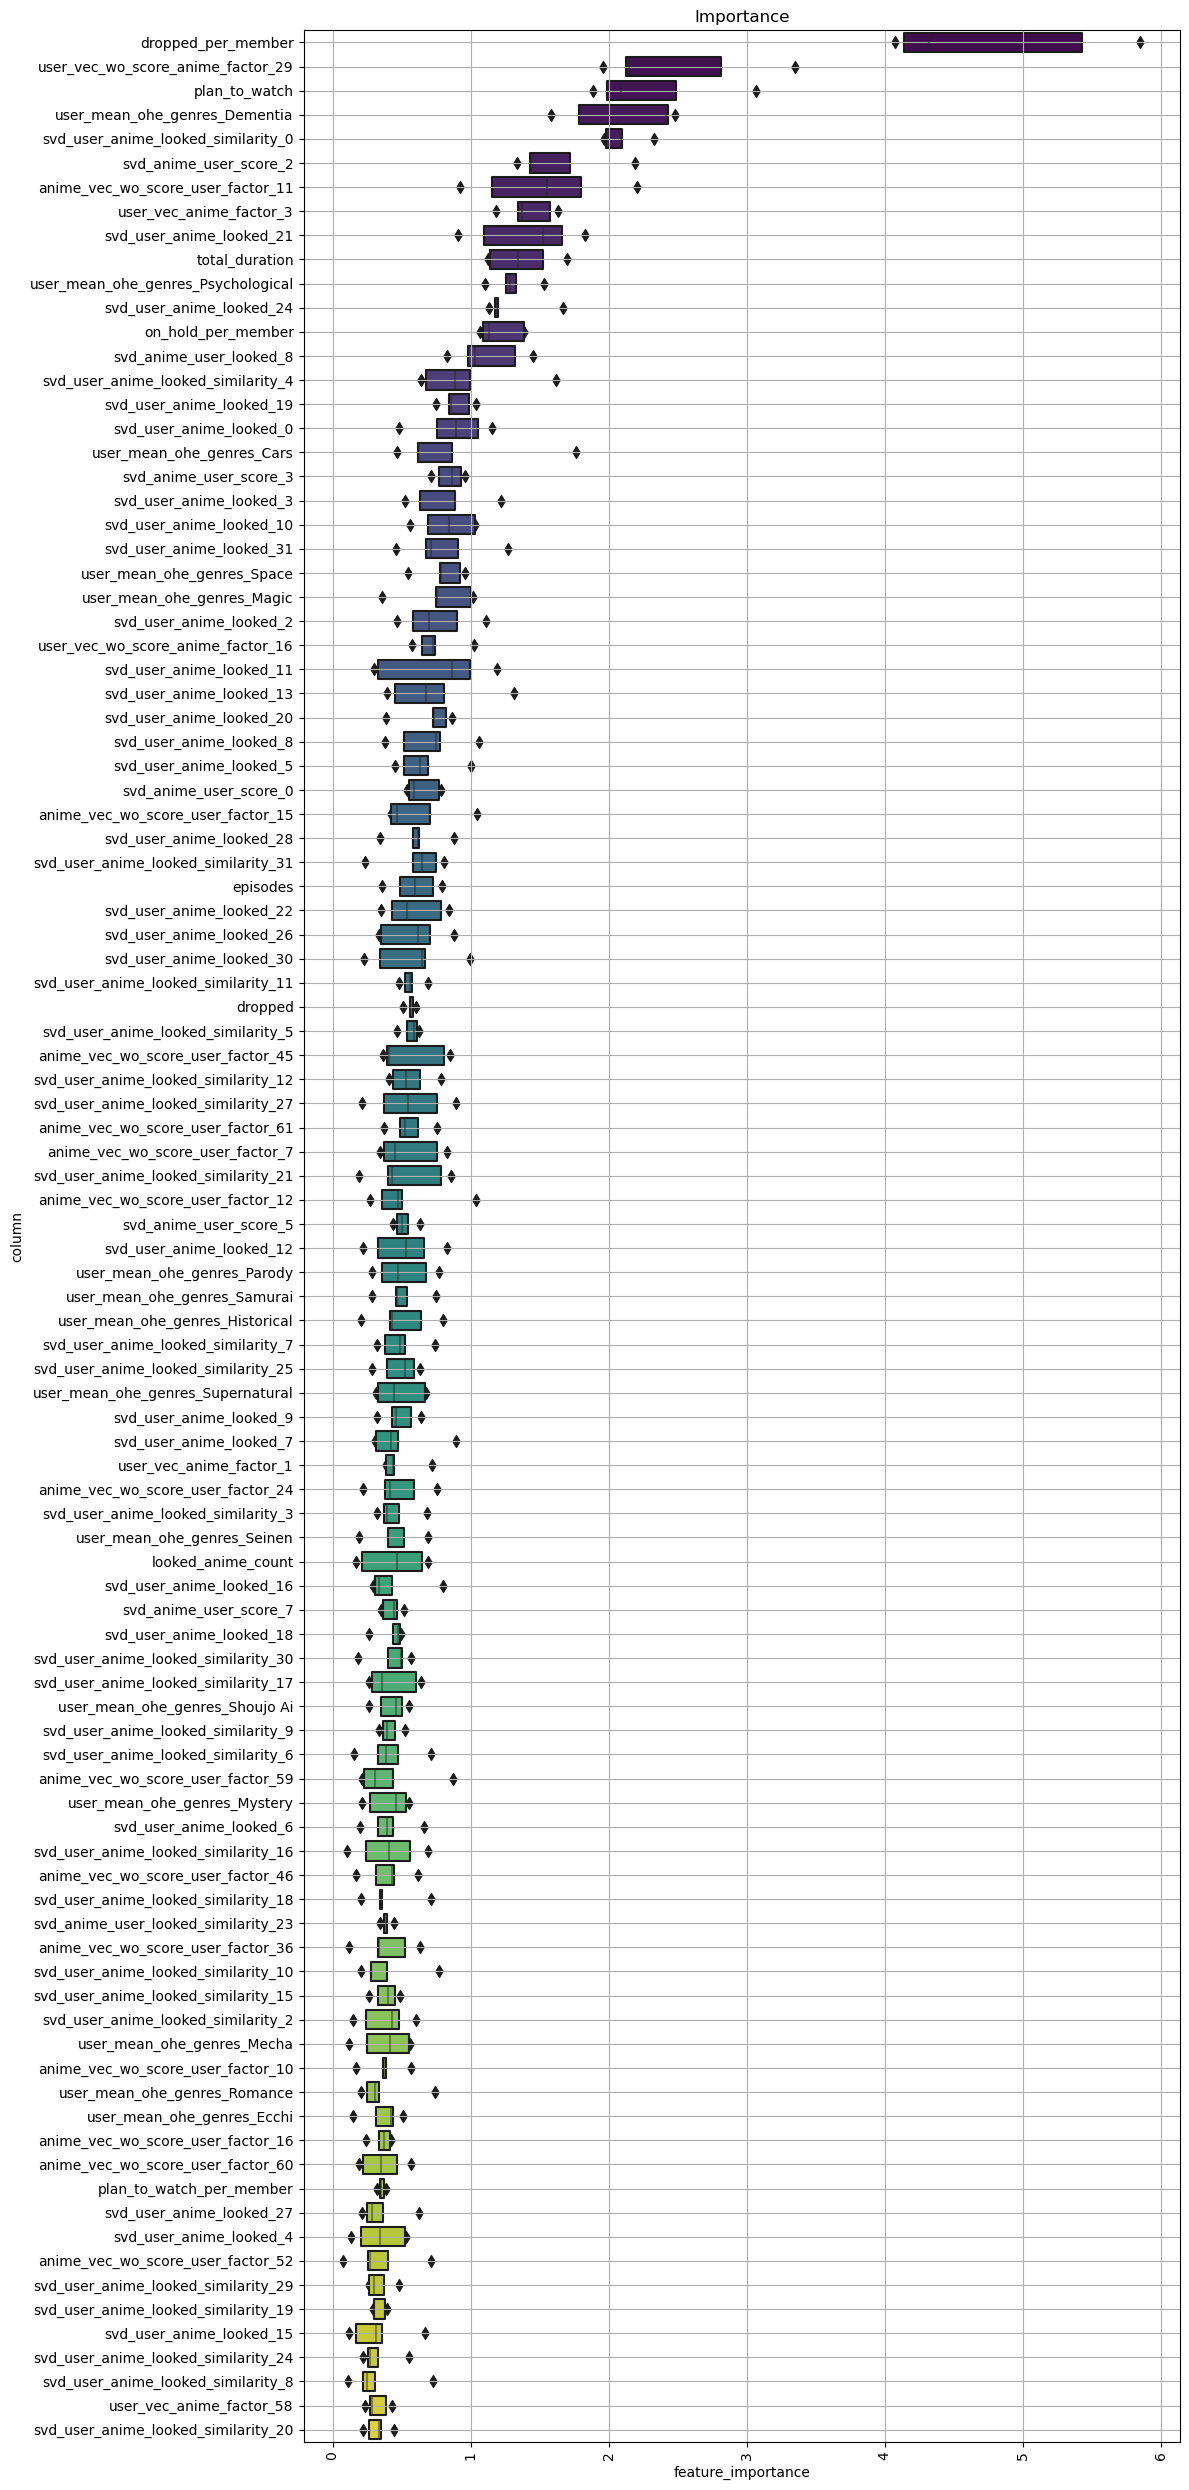

In [15]:
fig, ax = visualize_importance(models, train_data[feature_cols])

# Final_Process

In [16]:
test_seen_df["pred"] = np.mean(cat_test_preds, axis=0)
test_unseen_df["pred"] = np.mean(cat_test_preds2, axis=0)
final_test_df = pd.concat([test_seen_df, test_unseen_df]).reset_index(drop=True)
_test_df = test_df.merge(final_test_df[["user_id", "anime_id", "pred"]], on=["user_id", "anime_id"], how="left")
_test_df["pred2"] = _test_df['pred'].apply(lambda x: np.clip(x, 1, 10))

sub = pd.read_csv("/kaggle/input/atmacup-15dataset/sample_submission.csv")
sub["score"] = _test_df["pred2"]
sub.to_csv("seen_split_submission_20230722_02.csv", index=False)

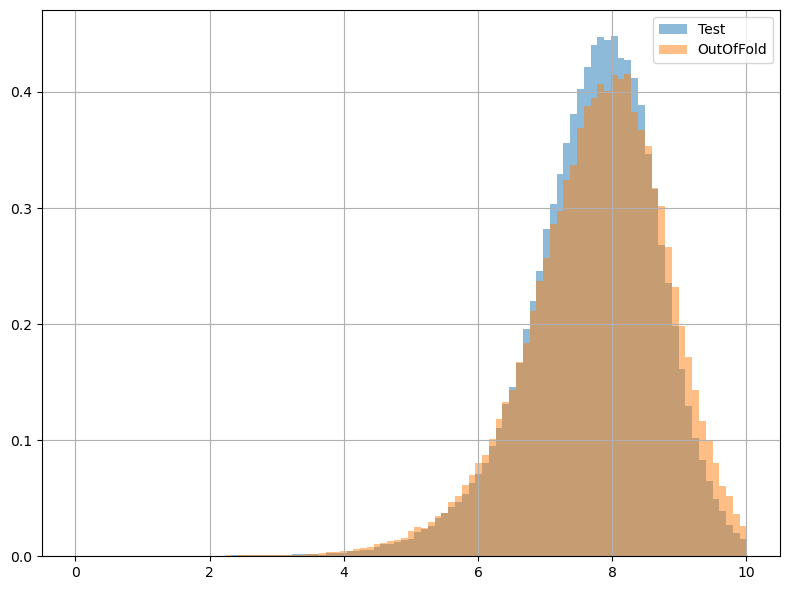

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = .02
bins = np.linspace(0, 10, 100)
ax.hist(final_test_df["pred"], bins=bins, density=True, alpha=.5, label="Test")
ax.hist(oof_df["cat_pred"], bins=bins, density=True, alpha=.5, label="OutOfFold")
ax.grid()
ax.legend()
# ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()